## Load a previously trained CNN and visualize Filters and Feature Maps

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim

import torchvision
import torchvision.transforms as transforms

#### Import CIFAR10 Testset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.CIFAR10(root = './data/CIFAR10'
                                      , train = False
                                      , download = False
                                      , transform = transform)

testloader = DataLoader(testset
                       , batch_size = 32
                       , shuffle = False
                       , num_workers = 1)

#### Define CNN as trained before

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 12, 3)
        self.conv3 = nn.Conv2d(12, 24, 3)
        
        self.fc1 = nn.Linear(24*4*4, 200)
        self.fc2 = nn.Linear(200, 120)
        self.fc3 = nn.Linear(120, 60)
        self.out = nn.Linear(60, 10)
    
    def forward(self, t):
        #print('conv1')
        t = self.conv1(t)
        t = F.relu(t)
        #print(t.shape)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        #print(t.shape)
        
        #print('conv2')
        t = self.conv2(t)
        t = F.relu(t)
        #print(t.shape)
        t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        #print(t.shape)
        
        #print('conv3')
        t = self.conv3(t)
        t = F.relu(t)
        #print(t.shape)
        #t = F.max_pool2d(t, kernel_size = 2, stride = 2)
        #print(t.shape)
        
        
        t = t.reshape(-1,24*4*4)
        #print('fc1 reshape:', t.shape)
        t = self.fc1(t)
        t = F.relu(t)
        
        t = self.fc2(t)
        t = F.relu(t)
        
        t = self.fc3(t)
        t = F.relu(t)
        
        t = self.out(t)
        #softmax?
        
        return t

#### Initialize and give trained params

In [4]:
cnn = CNN()

In [5]:
#load the params
path = './models/cifar10_selfbuild_params.pth'
params = torch.load(path)

In [6]:
#give params new CNN
cnn.load_state_dict(params)

<All keys matched successfully>

#### Try test set for verification of loaded, trained params

In [7]:
def test(model, test_loader):
    test_correct = 0
    
    with torch.no_grad():
        model.eval()
        for batch in test_loader:
            images, labels = batch
            preds = model(images)
        
            test_correct += preds.argmax(dim = 1).eq(labels).sum().item()
    
    test_accuracy = 100 * test_correct / len(test_loader.dataset)    
    print('Accuracy on TestSet in %:', test_accuracy)
    
    #return test_correct, test_accuracy

In [8]:
test(cnn, testloader) #works

Accuracy on TestSet in %: 40.33


#### Visualize the CNN's Filter

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
model_weights = [] #saving conv layer weights
conv_layers = [] #saving conv layers
amount = 0

model_children = list(cnn.children())

for layer in model_children:
    if type(layer) == nn.Conv2d:
        amount += 1
        model_weights.append(layer.weight)
        conv_layers.append(layer)
        
print('Amount of conv layers:', amount)

Amount of conv layers: 3


In [11]:
#Show Conv layers, and weight shapes
for layer, weights in zip(conv_layers, model_weights):
    print(f'Conv Layer: {layer} Shape: {weights.shape}')

Conv Layer: Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1)) Shape: torch.Size([6, 3, 3, 3])
Conv Layer: Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1)) Shape: torch.Size([12, 6, 3, 3])
Conv Layer: Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1)) Shape: torch.Size([24, 12, 3, 3])


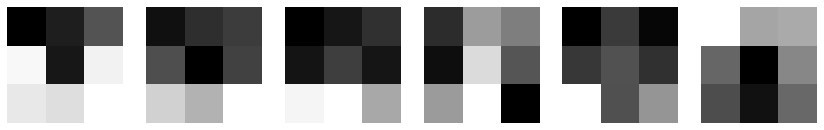

In [12]:
plt.figure(figsize = (17, 20))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(7,7, i+1)
    plt.imshow(filter[0, :, :].detach(), cmap = 'gray')
    plt.axis('off')
plt.show()

#### Visualize the CNN's Feature Maps

In [13]:
#Get one picture from the testset
img, lbl = next(iter(testloader))
img = img[0]
img = img.unsqueeze(0)

In [14]:
img.shape

torch.Size([1, 3, 32, 32])

In [15]:
def imshow(img):
    img = img / 2 + 0.5 #unormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

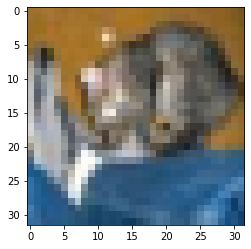

In [16]:
imshow(img[0])

In [17]:
#passing the img through the layers
results = [conv_layers[0](img)]
for layer in conv_layers[1:]:
    results.append(layer(results[-1]))
outputs = results 

torch.Size([6, 30, 30])


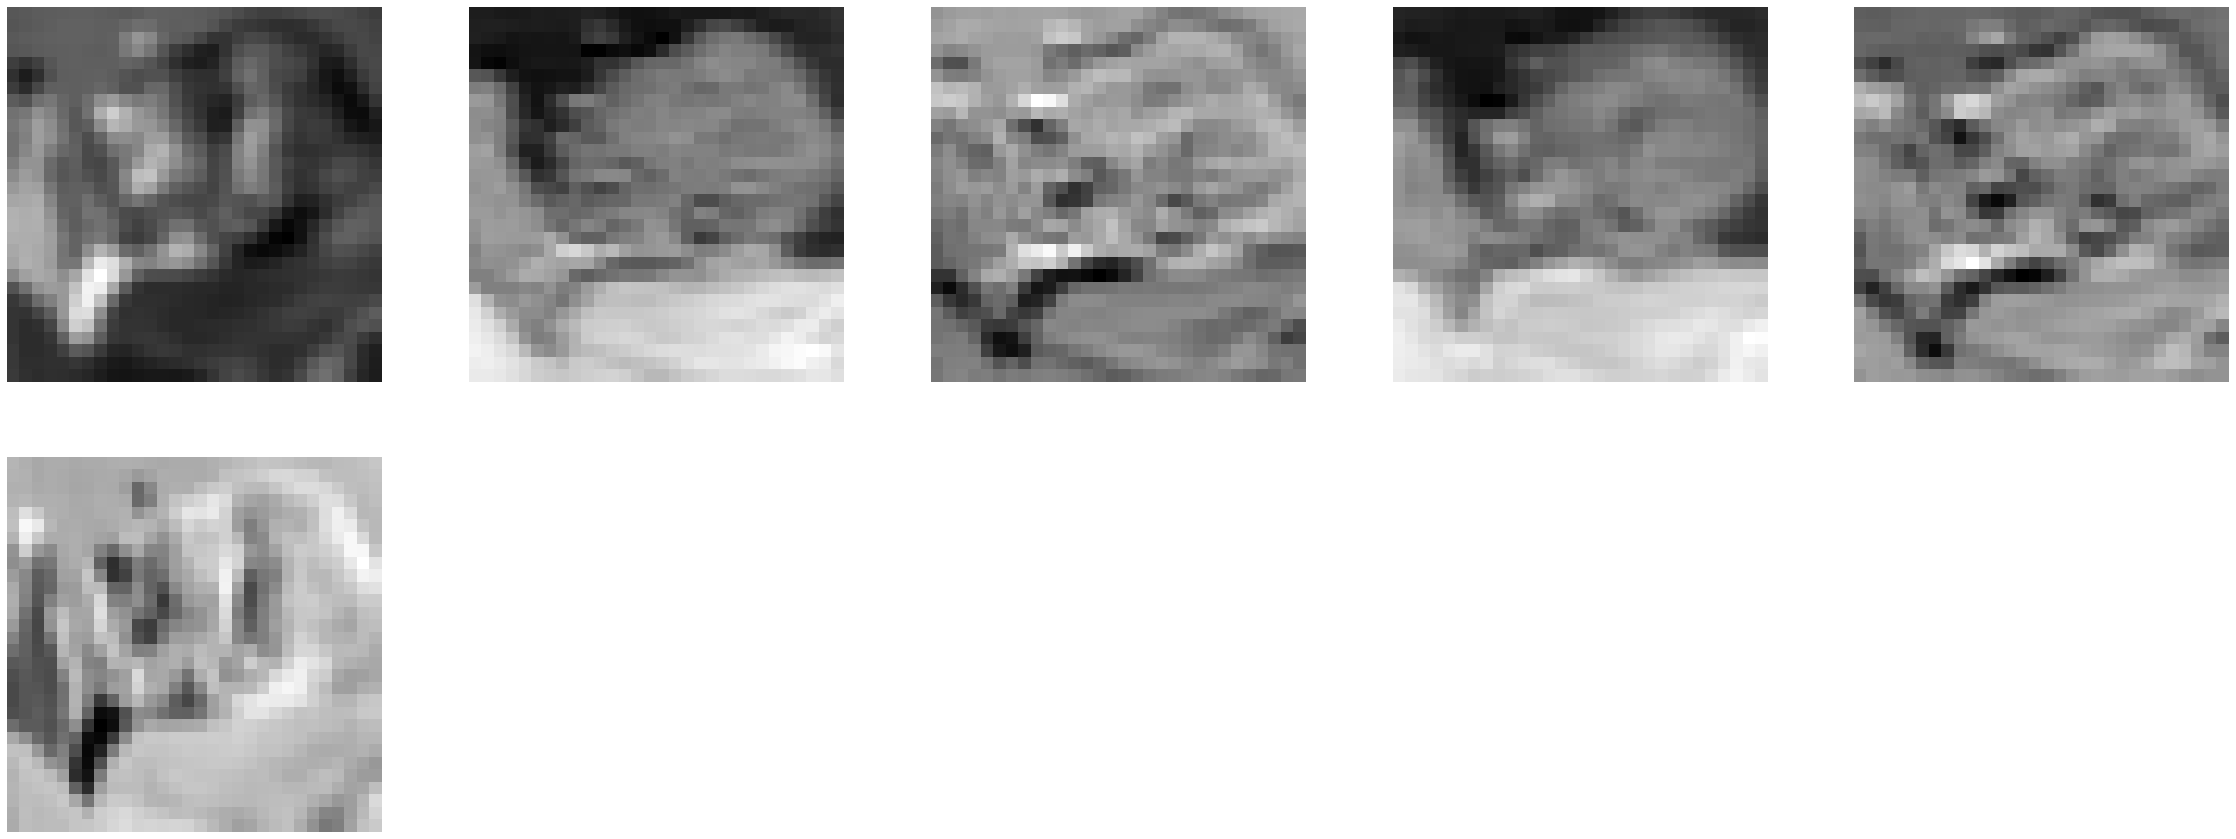

torch.Size([12, 28, 28])


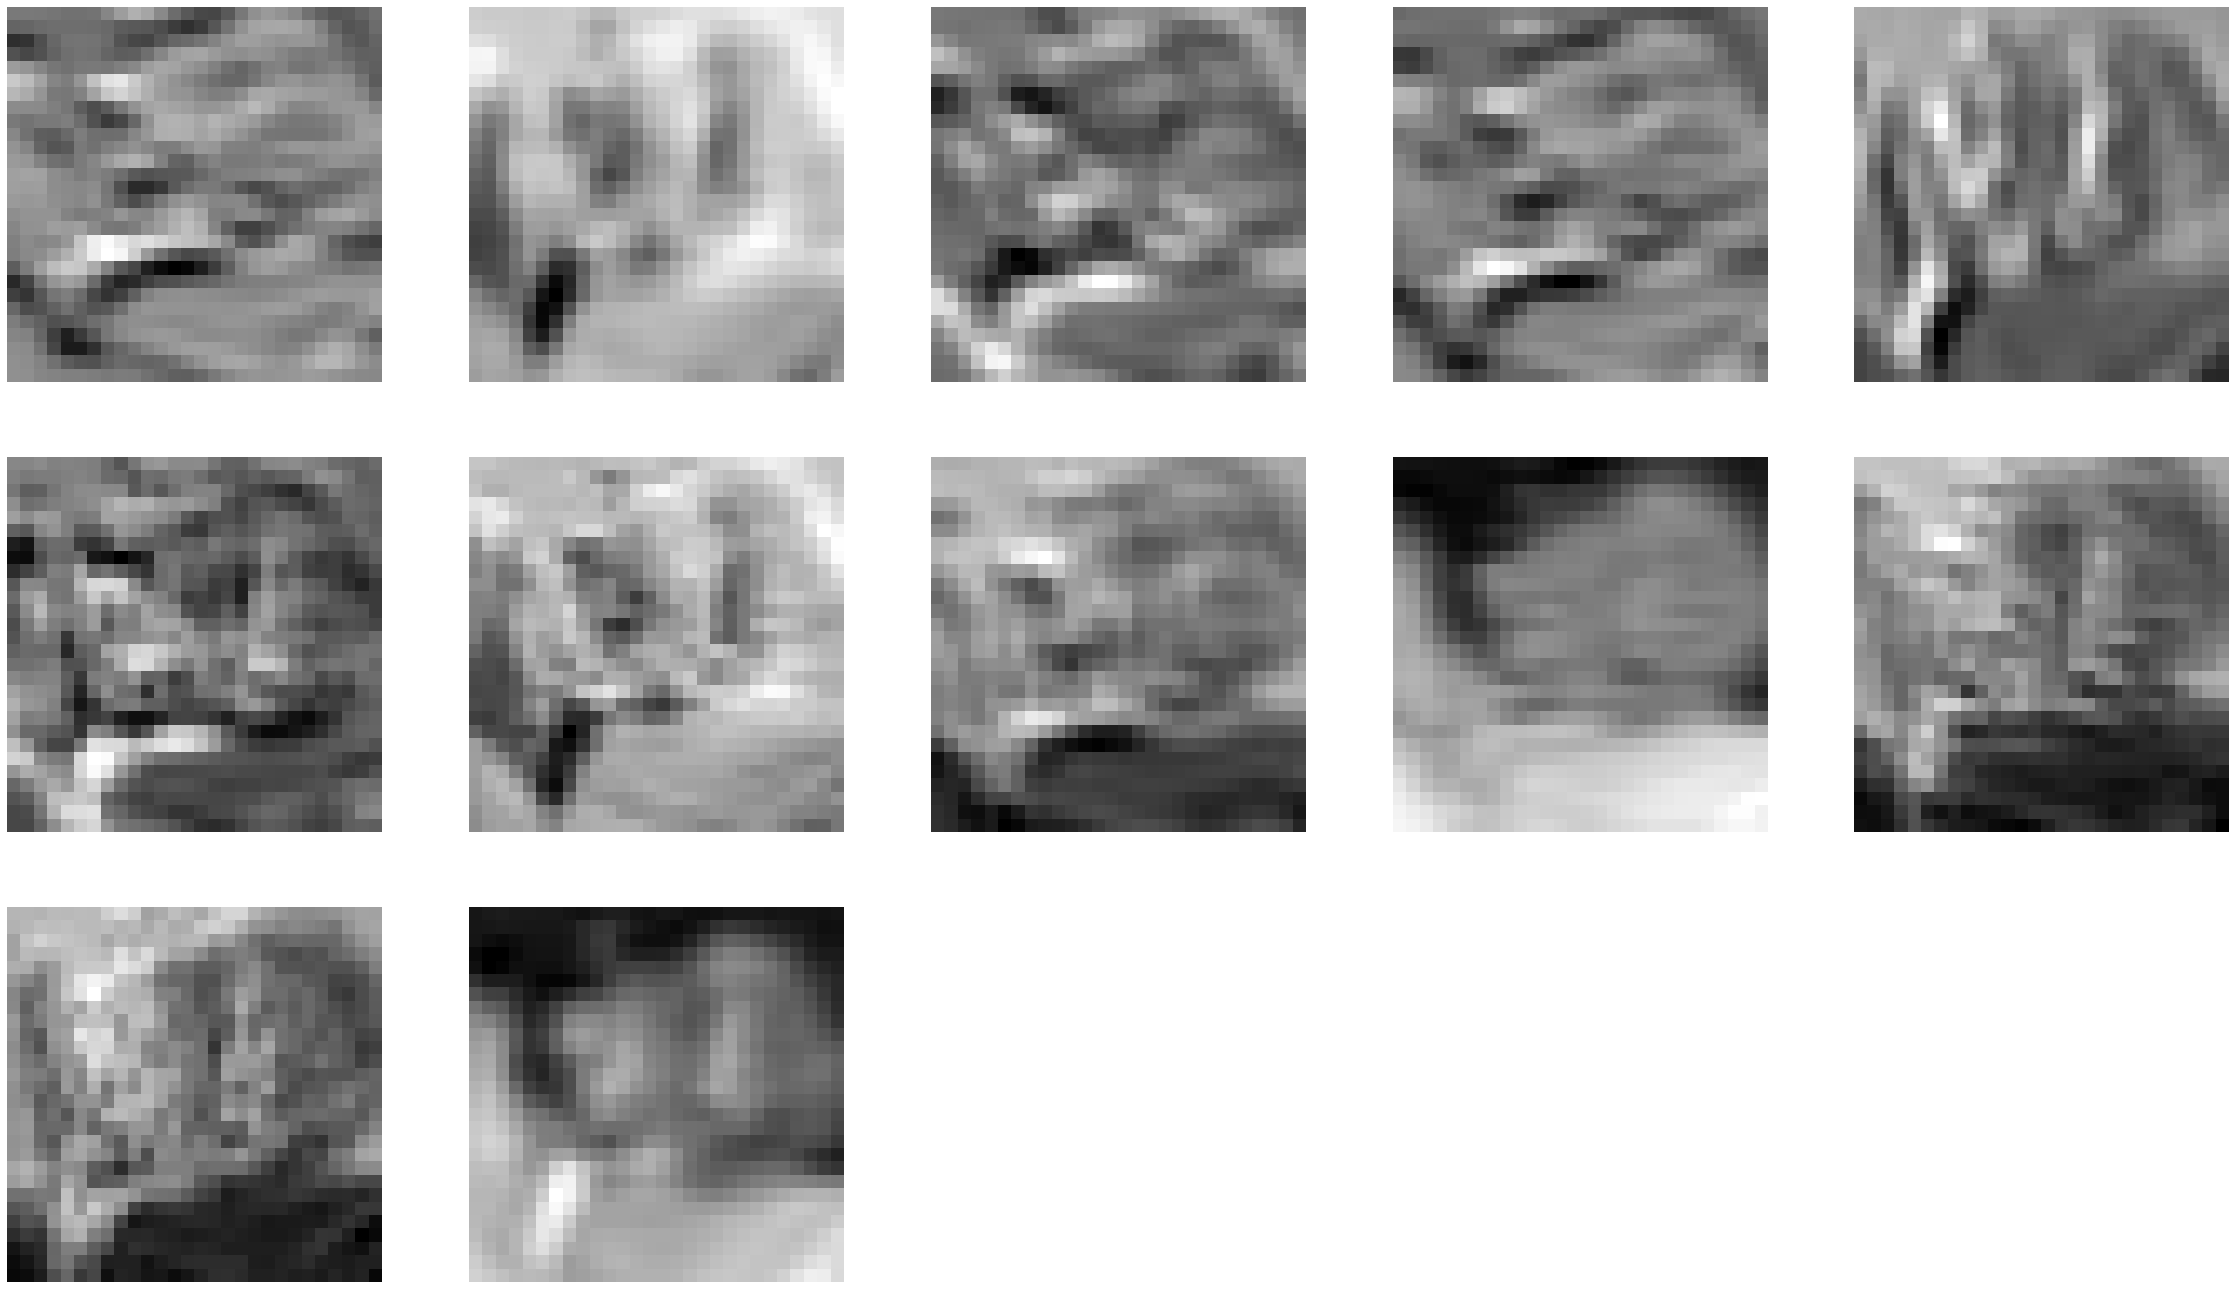

torch.Size([24, 26, 26])


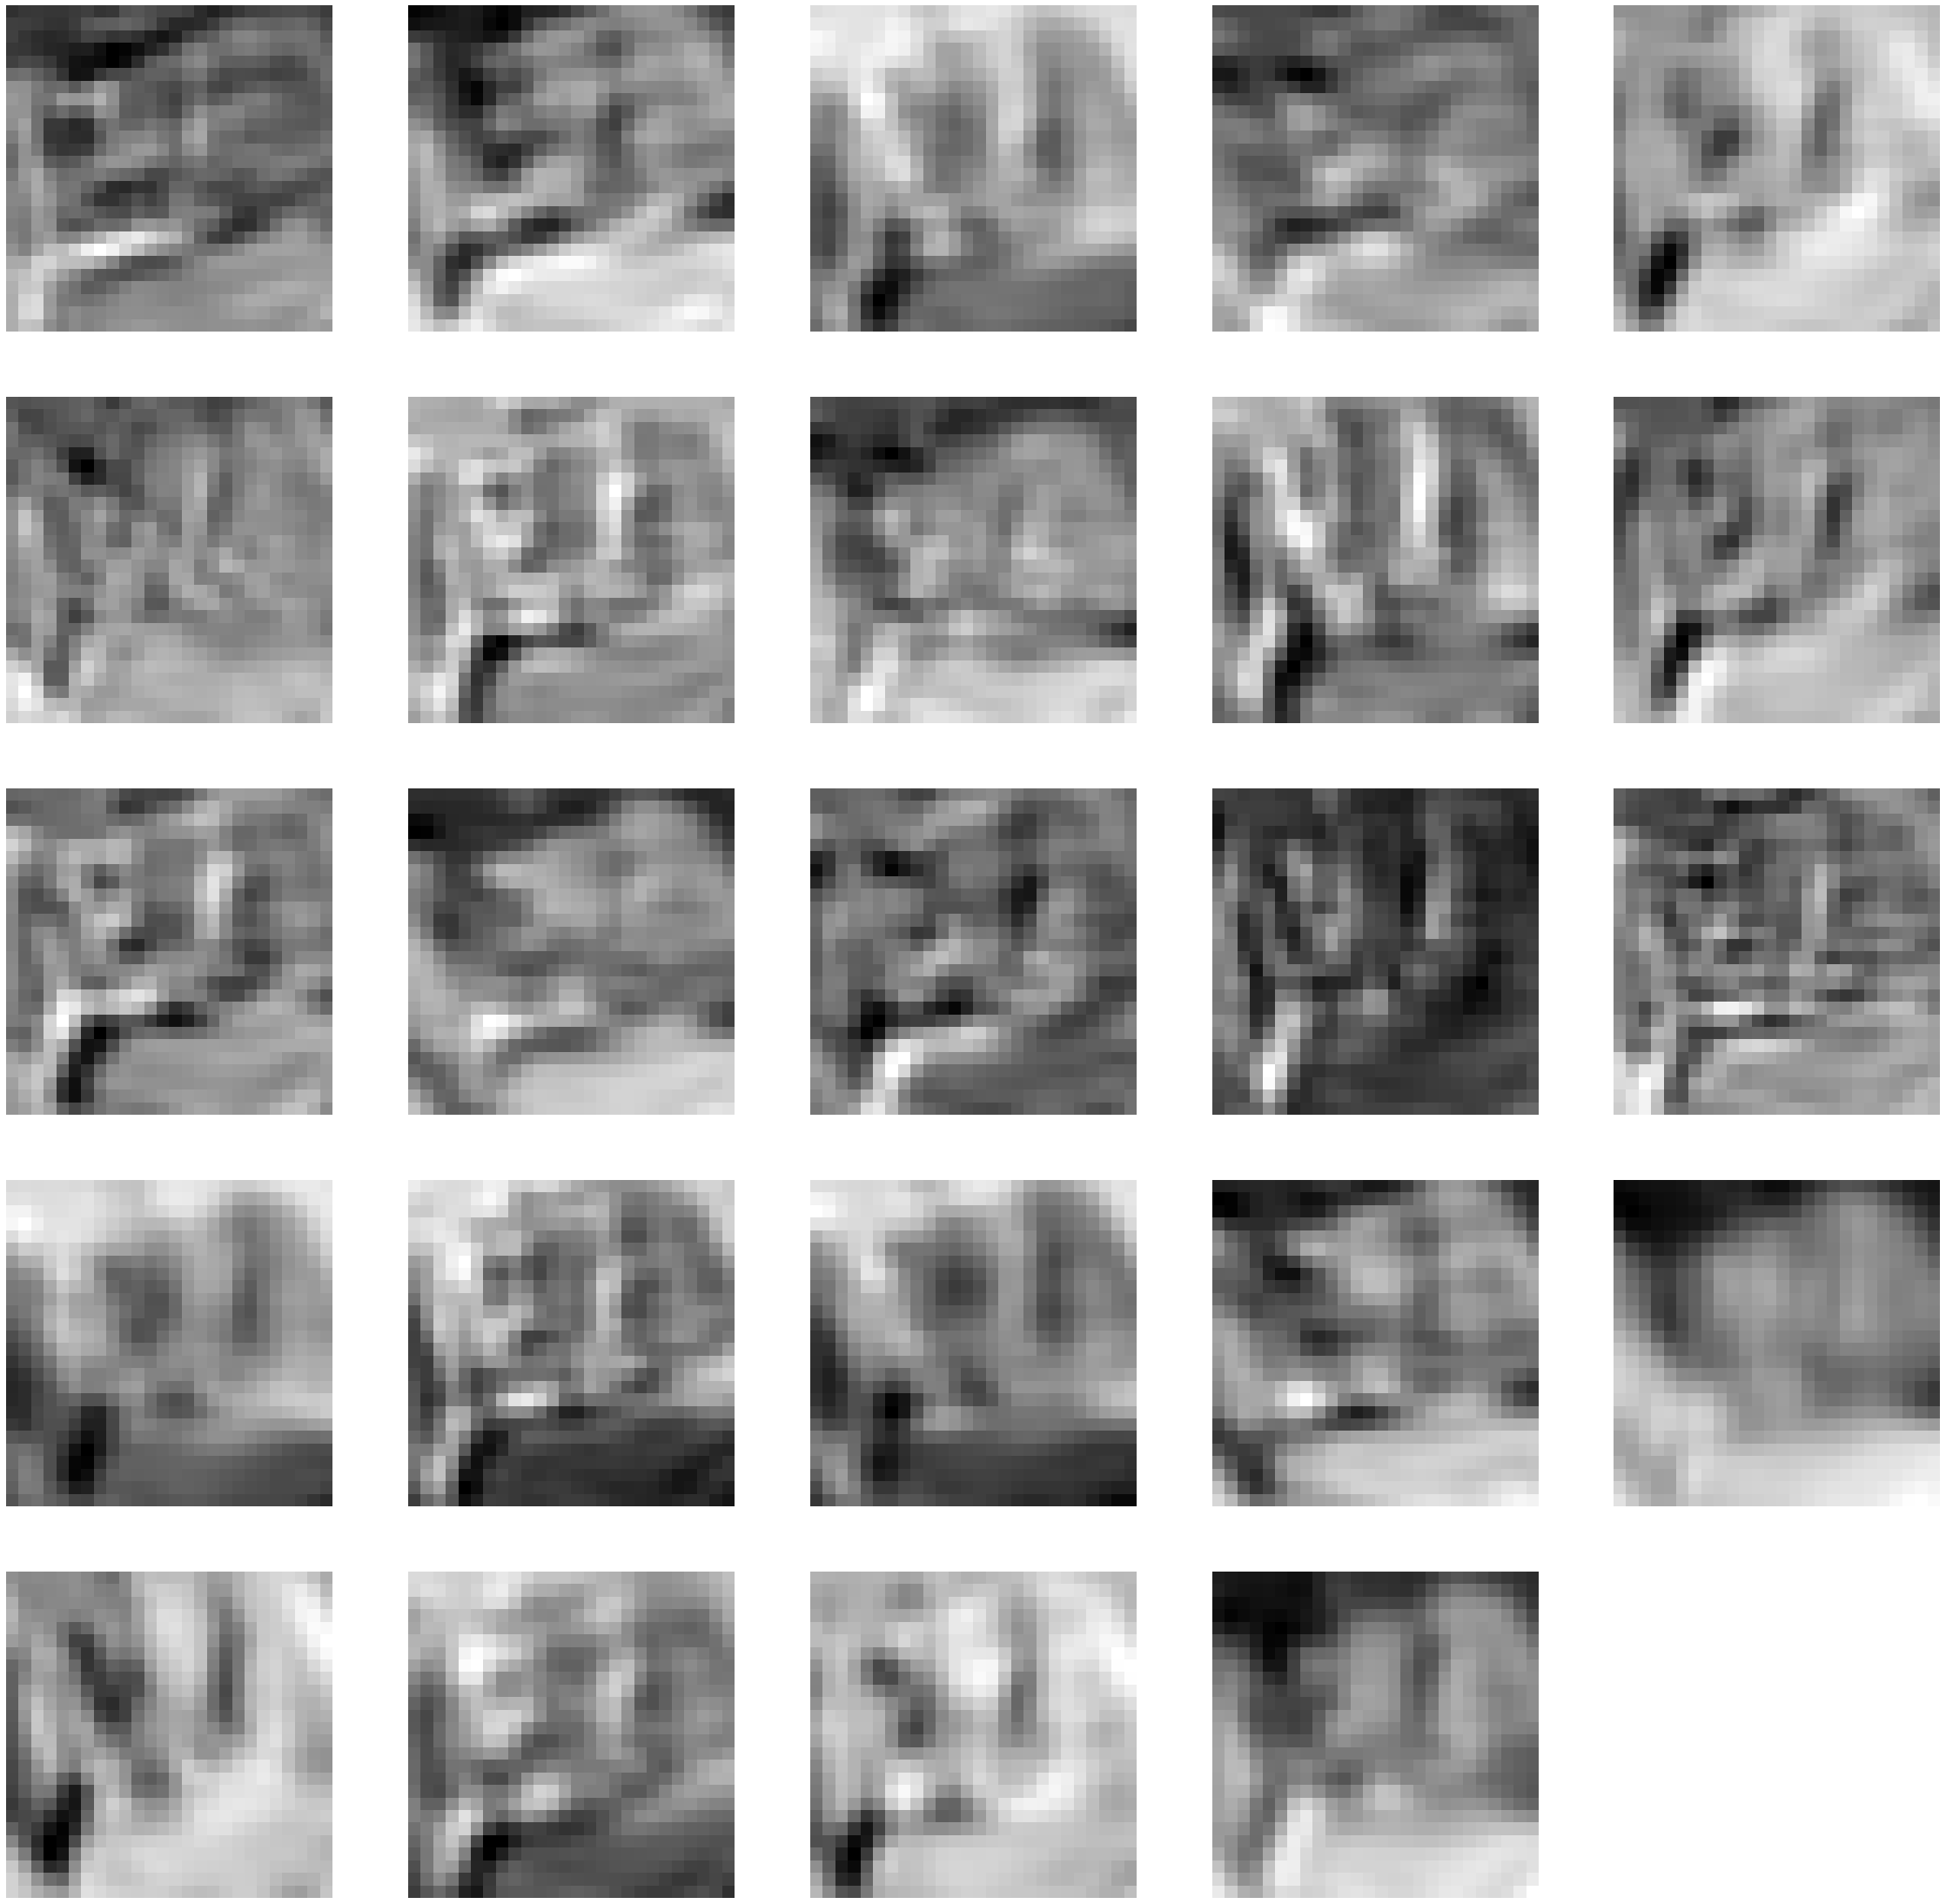

In [20]:
#Visualize the Feature Maps
for num_layer in range(len(outputs)):
    plt.figure(figsize=(40,40))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.shape)
    for i, filter in enumerate(layer_viz):
        plt.subplot(5, 5, i+1)
        plt.imshow(filter, cmap = 'gray')
        plt.axis('off')
    plt.show()